This notebook tries to implement the following paper:

_Adversarial Autoencoders_: https://arxiv.org/pdf/1511.05644.pdf


The model is built using Keras and trained using Keras

In [1]:
import numpy as np
import tensorflow as tf
from models import *
from keras import backend as K
from keras.layers import Input, Reshape, Flatten, Concatenate, Lambda
from keras.models import Model
from keras import initializers
import pandas as pd
from parse_dataset import *
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
batch_size = 64

In [3]:
data = pd.read_csv('../Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
def data_generator(data, last, idx, scaler, log_scaler, action_scaler, batch_size=batch_size, log_action=True, verbose=False):
    """used in fit_generator"""
    X_action_bin, X_features_bin, X_num, X_action, X_finished, X_alive = matrify(data, idx, scaler, log_scaler,action_scaler, verbose=False, log_action=log_action)
    while True:
        # shuffle
        X_action_bin, X_features_bin, X_num, X_action, X_finished, X_alive = shuffle(X_action_bin, X_features_bin, X_num, X_action, X_finished, X_alive)

        # take a part only
        if last is not None:
            X_action_bin, X_features_bin, X_num, X_action, X_finished, X_alive = X_action_bin[:last], X_features_bin[:last], X_num[:last], X_action[:last], X_finished[:last], X_alive[:last]

        # one-hot encode
        if verbose:
            iterator = tqdm(range(0, X_num.shape[0], batch_size))
        else:
            iterator = range(0, X_num.shape[0], batch_size)
        for i in iterator:
            x_action_bin = X_action_bin[i:i+batch_size]
            x_features_bin = X_features_bin[i:i+batch_size]
            x_num = X_num[i:i+batch_size]
            action = X_action[i:i+batch_size]
            finished = X_finished[i:i+batch_size]
            alive = X_alive[i:i+batch_size]
            if x_num.shape[0] != batch_size:
                continue
            
            time = np.fromfunction(lambda i,j,k: j, (batch_size, x_num.shape[1], 1))
            try:
                reshaped_finished = finished.reshape((batch_size, -1, 1))
            except ValueError:
                print(finished.shape)
                print(alive.shape)
                print(x_num.shape)
                print(x_action_bin.shape)
                print(x_features_bin.shape)
                raise ValueError
            reshaped_alive = alive.reshape((batch_size, -1, 1))
            x_num_i = np.concatenate((
                x_num,
                reshaped_finished,
                reshaped_alive,
                time), -1
            )
            
            yield [x_num_i, x_features_bin, x_action_bin, action], [x_num, finished, alive]

In [5]:
# PARAMS
epochs = 50

latent_dim = 100
num_filters = 20
nb_stack = 2
kernel_size = 2
BN = True
dropout = .1

# Models

In [6]:
def generator(n_gates=3, T=25, n_num_features=len(numerical_columns_not_to_be_logged + numerical_columns_to_be_logged),
               latent_dim=25, kernel_size=2, activation="prelu", BN=True, dropout=.1,
               n_binary_features=len(binary_features_columns), n_binary_actions=len(binary_actions_columns),
               l1_reg=0
               ):
    # UPSAMPLING OF LATENT CODE
    latent_vector = Input((latent_dim,))
    h_latent = Dense(n_num_features*T, activation=activation)(latent_vector)
    h_latent = Reshape((T, n_num_features))(h_latent)

    # CREATE AN INPUT FOR THE TEMPORAL DATA
    vitals = Input((T, n_num_features+3))  # numerical values
    vitals_ = Lambda(lambda x_: x_[:, :, :-3])(vitals)
    binary_features = Input((n_binary_features,))  # these are features that shouldn't be predicted (conditions). They don't depend on time...
    binary_features_ = Concatenate(1)(T * [Reshape((1, -1))(binary_features)])
    binary_actions = Input((T, n_binary_actions))  # binary values (gender, rrt, sedation, ...)
    actions = Input((T, 2))  # for each time step, two values: the VP and the IV. Can be continuous or discrete
    temporals = Conv1D(n_num_features, kernel_size=1, activation=activation, BN=BN, dropout=dropout)(
        Concatenate(-1)([vitals_, binary_features_, binary_actions, actions]))

    # STACKED WAVENET BLOCKS
    temporals, skip = CWaveNet(kernel_size, n_num_features, "a", dropout_x=dropout, dilation_rate=1, l1_reg=l1_reg)(temporals, h_latent)
    skip_connections = [skip]

    for k in range(n_gates - 1):
        temporals, skip = CWaveNet(kernel_size, n_num_features, "b", dropout_x=dropout,
                                   dilation_rate=2 ** (1 + k), l1_reg=l1_reg)(temporals, h_latent)
        skip_connections.append(skip)

    if len(skip_connections) > 1:
        temporals = Add()(skip_connections)
    temporals = Conv1D(n_num_features, 1, activation=activation, BN=BN, dropout=dropout, use_bias=not BN)(temporals)

    # for the numerical values, predict the difference from the previous state, to learn relative rather than absolute target. Hope that it can generalize better
    switched_vitals = Lambda(lambda x: x[:, :-1, :-3])(ZeroPadding1D(padding=(1, 0))(vitals))  # basically shift the input sequence to the right
    delta_vitals = Conv1D(n_num_features, 1, activation=None, BN=BN, dropout=None, use_bias=not BN)(temporals)
    next_vitals = Add(name='vitals')([switched_vitals, delta_vitals])
    finished = Flatten(name='finished')(Conv1D(1, 1, activation="sigmoid", BN=BN, dropout=None, use_bias=not BN)(temporals))  # whether it is the end of the sequence or not. Might not be needed ???
    dead_or_alive = Flatten(name='alive')(Conv1D(1, 1, activation="sigmoid", BN=BN, dropout=None, use_bias=not BN)(temporals))  # whether the patient is alive (1) or not (0)
    G = Model([vitals, binary_features, binary_actions, actions, latent_vector], [next_vitals, finished, dead_or_alive])
    return G

In [7]:
def encoder(num_filters=20, kernel_size=2, T=25, n_num_features=len(numerical_columns_not_to_be_logged + numerical_columns_to_be_logged), latent_dim=25, BN=True, activation="prelu", dropout=.1, n_binary_features=len(binary_features_columns),
             n_binary_actions=len(binary_actions_columns)):
    binary_features = Input((n_binary_features,))  # these are features that shouldn't be predicted (conditions). They don't depend on time...
    binary_features_ = Concatenate(1)(T * [Reshape((1, -1))(binary_features)])
    binary_actions = Input((T, n_binary_actions))  # these are actions that shouldn't be predicted (conditions)
    vitals = Input((T, n_num_features+3))  # +3 for time, alive, finished
    actions = Input((T, 2))  # for each time step, two values: the VP and the IV. # including the actions is necessary: it is part of the history. Architecturally, it corresponds to a CVAE

    x = Concatenate(-1)([vitals, binary_features_, binary_actions, actions])
    h = Conv1D(num_filters, kernel_size, activation=activation, BN=BN, dropout=dropout, padding='causal', use_bias=not BN)(x)
    h = Conv1D(num_filters, kernel_size, activation=activation, BN=BN, dropout=dropout, padding="causal",
               dilation_rate=2, use_bias=not BN)(h)
    h = Conv1D(num_filters, kernel_size, activation=activation, BN=BN, dropout=dropout, padding="causal",
               dilation_rate=4, use_bias=not BN)(h)
    h = Conv1D(num_filters, kernel_size, activation=activation, BN=BN, dropout=dropout, padding="causal",
               dilation_rate=8, use_bias=not BN)(h)
    h = Conv1D(1, 1, activation=activation, BN=BN, dropout=dropout, use_bias=not BN)(h)
    h = Flatten()(h)
    h = Dense(latent_dim, activation=activation)(h)

    z_mean = Dense(latent_dim)(h)
    z_var = Dense(latent_dim, activation='softplus')(h)
    E = Model([vitals, binary_features, binary_actions, actions], [z_mean, z_var])
    return E

In [8]:
def discriminator(n=100):
    z = Input((latent_dim,))
    
    proba = Dense(n,activation='selu')(z)
    proba = Dense(n,activation='selu')(proba)
    proba = Dense(n,activation='selu')(proba)
    proba = Dense(1, activation='sigmoid')(proba)
    
    D = Model(z, proba)

    return D

# Define graphs

In [9]:
from keras.optimizers import Adam
from keras import objectives

In [10]:
E = encoder(num_filters=num_filters, latent_dim=latent_dim)
G = generator(n_gates=2, latent_dim=latent_dim)
D = discriminator()

In [11]:
def sample_z(batch_size, latent_dim, epsilon_std):
    return lambda args: _sampling(args, batch_size, latent_dim, epsilon_std)

def _sampling(args, batch_size, latent_dim, epsilon_std):
    z_mean, z_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.sqrt(z_var) * epsilon

In [12]:
# x -> z
vitals, binary_features, binary_actions, actions = E.inputs
z_mean, z_var = E([vitals, binary_features, binary_actions, actions])  # we need those to compute KL divergence, so it cannot be directly included in the encoder function
z = Lambda(sample_z(batch_size, latent_dim, 1.), output_shape=(latent_dim,))([z_mean, z_var])

next_vitals, finished, dead_or_alive = G([vitals, binary_features, binary_actions, actions, z])
VAE = Model([vitals, binary_features, binary_actions, actions], [next_vitals, finished, dead_or_alive])

VAE.output_names = G.output_names
VAE.compile(loss={'vitals': 'mean_squared_error', 'finished': 'binary_crossentropy', 'alive': 'binary_crossentropy'}, 
            loss_weights={'vitals': 1., 'finished': 1., 'alive': 1.},
            metrics={'finished': 'accuracy', 'alive': 'accuracy'},
            optimizer=Adam())

In [13]:
# z -> p
# update the discriminator weights on its ability to detect fake from real samples
z = Input((latent_dim,))
proba = D(z)

D_from_z = Model(z, proba)
D_from_z.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer=Adam(lr=0.0002))

In [14]:
# x -> z -> p
n_binary_features = 2
n_binary_actions = 3
n_num_features = 45
T = 25
# update the encoder weights on its ability to fool the discriminator. The latter isn't trained
binary_features = Input((n_binary_features,))  # these are features that shouldn't be predicted (conditions). They don't depend on time...
binary_actions = Input((T, n_binary_actions))  # these are actions that shouldn't be predicted (conditions)
vitals = Input((T, n_num_features+3))  # +3 for time, alive, finished
actions = Input((T, 2))
mean,var = E([vitals, binary_features, binary_actions, actions])
z = Lambda(sample_z(batch_size, latent_dim, 1.), output_shape=(latent_dim,))([mean, var])

proba = D(z)
D.trainable = False

D_from_tserie = Model([vitals, binary_features, binary_actions, actions], proba)

D_from_tserie.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=Adam(lr=0.0002))

## Training steps

In [15]:
def train_vae(x_num_i, x_features_bin, x_action_bin, action, x_num, finished, alive):
    """The VAE tries to reconstruct the input"""
    return VAE.train_on_batch([x_num_i, x_features_bin, x_action_bin, action], [x_num, finished, alive])

In [16]:
def train_d(x_num_i, x_features_bin, x_action_bin, action, z_sampled):
    """The discriminator tries to distinguish samples from the true prior N(0,I) from those of the encoded distribution"""
    zmean, zvar = E.predict([x_num_i, x_features_bin, x_action_bin, action])
    all_latent = np.concatenate((zmean, z_sampled), 0)
    coming_from_prior = np.array(batch_size*[0] + batch_size*[1])
    return D_from_z.train_on_batch(all_latent, coming_from_prior)

In [17]:
def train_e(x_num_i, x_features_bin, x_action_bin, action):
    """The encoder tries to fool the discriminator into thinking that the encoded distribution is real"""
    coming_from_prior = np.array(batch_size*[1])
    return D_from_tserie.train_on_batch([x_num_i, x_features_bin, x_action_bin, action], coming_from_prior)

## Train VAE+GAN

Train generator and discriminator alternatively

In [18]:
def moving_average(data, window=10):
    n = len(data)
    if n == 0:
        return []
    new_data = [data[0]]
    for k, y in enumerate(data[1:]):
        new_data.append(np.mean(data[k - min(window, k):k+1]))
    return new_data

In [19]:
import matplotlib.pyplot as plt
from IPython import display

def plot_accuracy(loss_v, acc_v, loss_d, acc_d, loss_e, acc_e):
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(15,10))
    
    ax1 = fig.add_subplot(331)
    ax1.plot(moving_average(loss_v, window=25), label="reconstruction loss - 25")
    ax1.plot(moving_average(loss_v, window=250), label="reconstruction loss - 250")
    plt.legend()
    
    ax2 = fig.add_subplot(332)
    ax2.plot(moving_average(loss_d, window=25), label="discriminator loss - 25")
    ax2.plot(moving_average(loss_d, window=250), label="discriminator loss - 250")
    plt.legend()

    ax3 = fig.add_subplot(333)
    ax3.plot(moving_average(loss_e, window=25), label="encoder loss - 25")
    ax3.plot(moving_average(loss_e, window=250), label="encoder loss - 250")
    plt.legend()

    ax4 = fig.add_subplot(334)
    ax4.plot(moving_average(acc_v, window=25), label="reconstruction acc - 25")
    ax4.plot(moving_average(acc_v, window=250), label="reconstruction acc - 250")
    plt.legend()
    
    ax5 = fig.add_subplot(335)
    acc_d_ma = moving_average(acc_d, window=25)
    ax5.plot(acc_d_ma, label="discriminator acc - 25")
    ax5.plot(moving_average(acc_d, window=250), label="discriminator acc - 250")
    plt.legend()

    ax6 = fig.add_subplot(336)
    acc_e_ma = moving_average(acc_e, window=25)
    ax6.plot(acc_e_ma, label="encoder acc - 25")
    ax6.plot(moving_average(acc_e, window=250), label="encoder acc - 250")
    plt.legend()
    
#     ax7 = fig.add_subplot(337)
#     ax7.plot(moving_average(kl_divs, window=25), label="kl div - 25")
#     ax7.plot(moving_average(kl_divs, window=250), label="kl div - 250")
#     plt.legend()
    
    plt.show()
    
    try:
        return acc_d_ma[-1], acc_e_ma[-1]
    except:
        return 0.5, 0.6

In [20]:
epochs = 50
last_test = ((test_idx.shape[0] // batch_size)*batch_size) - test_idx.shape[0]
last_test = test_idx.shape[0] if last_test == 0 else last_test
last_train = ((train_idx.shape[0] // batch_size)*batch_size) - train_idx.shape[0]
last_train = train_idx.shape[0] if last_train == 0 else last_train

train_steps = train_idx[:last_train].shape[0]/batch_size
val_steps = test_idx[:last_test].shape[0]/batch_size

In [21]:
X_action_bin, X_features_bin, X_num, X_action, X_finished, X_alive = matrify(data, test_idx[:last_test], scaler, log_scaler,action_scaler)

896it [00:05, 170.87it/s]


In [23]:
import tqdm 
import time
from sklearn.decomposition import PCA

counter = 0
PLOT_PERIOD = 1000
DISC_PERIOD = 150
n_batch = 3000

acc_ds = []
acc_es = []
acc_vs = []
loss_ds = []
loss_es = []
loss_vs = []

training_d = True

for k in tqdm.tqdm(range(epochs)):
    t0 = time.time()
    for i, ([x_num_i, x_features_bin, x_action_bin, action], [x_num, finished, alive]) in enumerate(data_generator(data, last_train, train_idx, scaler, log_scaler, action_scaler, batch_size=batch_size, verbose=False)):
        if i > n_batch:
            break
        
        if i % 3 == 0:
            loss_tot, mse, bin_ent1, bin_ent2, acc_finished, acc_alive = train_vae(x_num_i, x_features_bin, x_action_bin, action, x_num, finished, alive)
            loss_vs.append(loss_tot)
            acc_vs.append(acc_alive)
        
        if training_d:
            if i % 3 == 1:
                z_sampled = np.random.normal(0., 1., (batch_size, latent_dim))
                loss_d, acc_d = train_d(x_num_i, x_features_bin, x_action_bin, action, z_sampled)
                loss_ds.append(loss_d)
                acc_ds.append(acc_d)

        if i % 3 == 2:
            loss_e, acc_e = train_e(x_num_i, x_features_bin, x_action_bin, action)
            loss_es.append(loss_e)
            acc_es.append(acc_e)
        
        if i % PLOT_PERIOD == 0:
            acc_d_ma, acc_e_ma = plot_accuracy(loss_vs, acc_vs, loss_ds, acc_ds, loss_es, acc_es)
            
            mean, var = E.predict([
            np.concatenate((
                    X_num, 
                    X_finished.reshape((X_num.shape[0], -1, 1)),
                    X_alive.reshape((X_num.shape[0], -1, 1)),
                    np.fromfunction(lambda i,j,k: j, (X_num.shape[0], X_num.shape[1], 1))
                ), -1),
                X_features_bin, 
                X_action_bin, 
                X_action]
            )
            pca = PCA(n_components=2)
            proj = pca.fit_transform(mean)
            plt.scatter(proj[:, 0], proj[:, 1])
#             gauss = np.random.normal()
            plt.show()
            
        if i % DISC_PERIOD == 0:
            if acc_d_ma >= 0.85:
                training_d = False
                print('stopped training d')
            if acc_e_ma >= 0.85:
                training_d = True
                print('started training d')
        
#         if k < 1 and i < 500:
#             training_d = False
        
#         print("average norm of E predictions: %s" % str(np.mean(np.sum(E.predict(x_batch)**2, -1))))

KeyboardInterrupt: 

# Testing

In [24]:
mean, var = E.predict([
            np.concatenate((
                    X_num, 
                    X_finished.reshape((X_num.shape[0], -1, 1)),
                    X_alive.reshape((X_num.shape[0], -1, 1)),
                    np.fromfunction(lambda i,j,k: j, (X_num.shape[0], X_num.shape[1], 1))
                ), -1),
                X_features_bin, 
                X_action_bin, 
                X_action]
            )


In [25]:
kl_loss = - 0.5 * np.sum(1 + np.log(var+1e-8) - np.square(mean) - var, axis=-1)
kl_loss.mean()

325.42996

In [28]:
z = mean + np.sqrt(var)*np.random.normal(size=(896,latent_dim))
decoded, finished, alive = G.predict([np.concatenate((
                X_num, 
                X_finished.reshape((X_num.shape[0], -1, 1)),
                X_alive.reshape((X_num.shape[0], -1, 1)),
                np.fromfunction(lambda i,j,k: j, (X_num.shape[0], X_num.shape[1], 1))
            ), -1), X_features_bin, X_action_bin, X_action, z])

In [30]:
(np.abs(X_finished.sum(-1) - finished.sum(-1)) <= 1).sum() / finished.shape[0]

0.9988839285714286

In [31]:
end = (25 - X_finished.sum(-1)).astype(np.int32)
alive_at_end = np.zeros(alive.shape[0])
for i, (end_, row) in enumerate(zip(end, (alive>.82).astype(np.int32))):
    alive_at_end[i] = row[end_+2]

survival_predictions = alive_at_end
real_survival_values = X_alive[:,-1]

In [32]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(real_survival_values, survival_predictions)
print(m)
print(0, m[0,0]/ (m[0,0]+m[0,1]))
print(1, m[1,1]/(m[1,1]+m[1,0]))

[[204   0]
 [  0 692]]
0 1.0
1 1.0


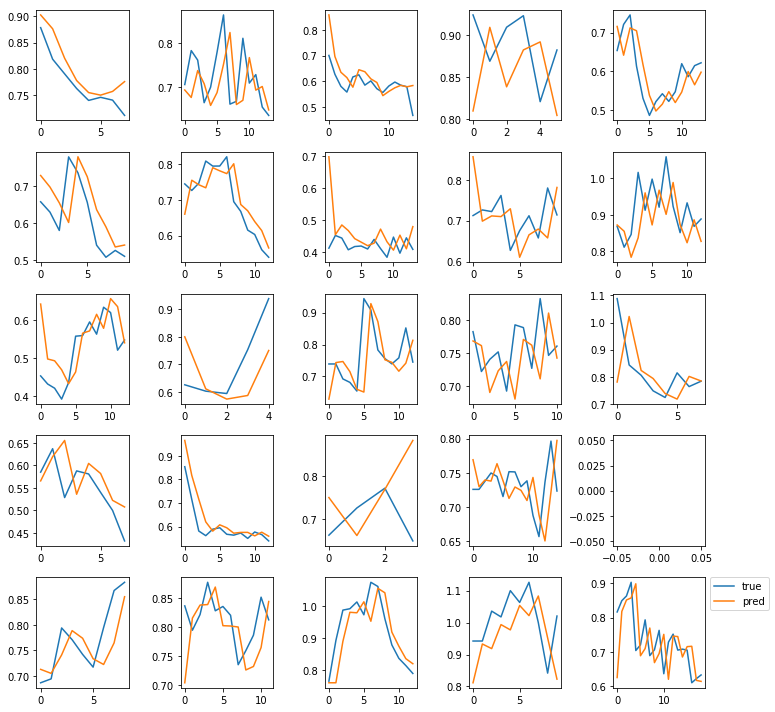

In [44]:
from matplotlib import pyplot as plt
from itertools import product
plt.rcParams['figure.figsize'] = (10,10)
fig, axes = plt.subplots(nrows=5, ncols=5)
qty = 10

for i,j in product(range(5), range(5)):
    idx = i + 5*j
    axes[i,j].plot(X_num[idx,:,qty][:end[idx]]*scaler.scale_[qty] + scaler.mean_[qty], label='true')
    axes[i,j].plot(decoded[idx,:,qty][:end[idx]]*scaler.scale_[qty] + scaler.mean_[qty], label='pred')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [36]:
decoded_histories =[]
for _ in range(10):
    random_z = mean[:1] + np.sqrt(var[:1])*np.random.normal(size=(25,1))
    decoded_histories.append(G.predict([np.concatenate((
                X_num,
                X_finished.reshape((X_num.shape[0], -1, 1)),
                X_alive.reshape((X_num.shape[0], -1, 1)),
                np.fromfunction(lambda i,j,k: j, (X_num.shape[0], X_num.shape[1], 1))
            ), -1)[:1], X_features_bin[:1], X_action_bin[:1], X_action[:1], random_z])[0])

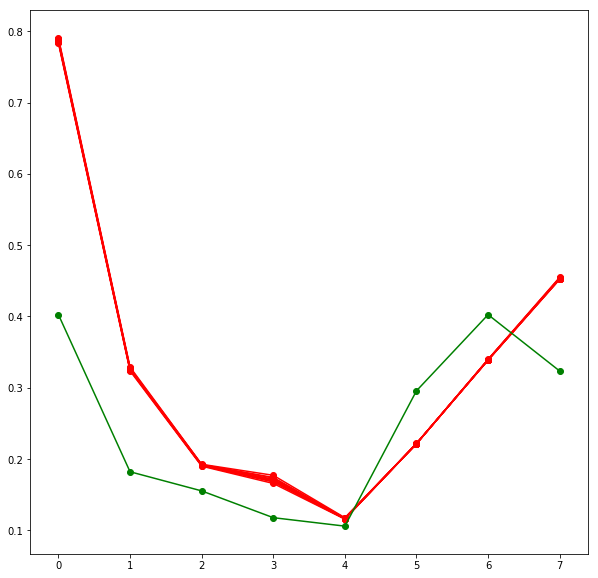

In [37]:
qty = 5
idx = 0
for decoded_history in decoded_histories:
    plt.scatter(list(range(end[idx])),decoded_history[0, :end[idx], qty], c='red')
    plt.plot(decoded_history[0, :end[idx], qty], c='red')
plt.scatter(list(range(end[idx])), X_num[0, :end[idx], qty], c='green')
plt.plot(X_num[0, :end[idx], qty], c='green')
plt.show()

In [38]:
from scipy.stats import chi2

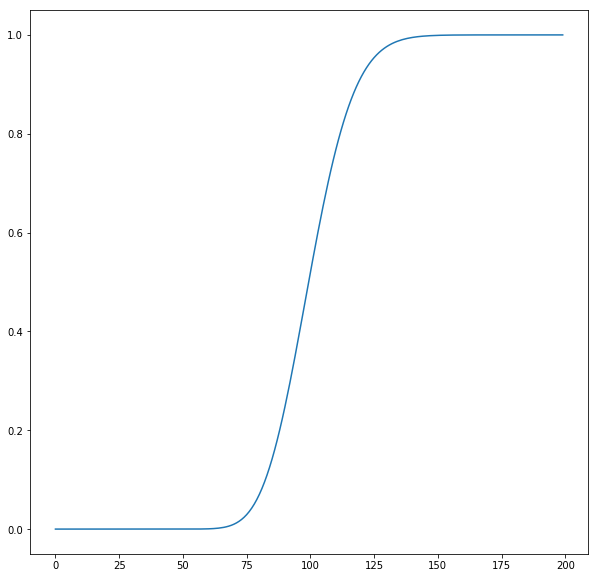

In [43]:
plt.plot(chi2.cdf(np.arange(0, 200), df=100))
plt.show()